In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("raw_results/distilbert-base-multilingual-cased__opus100.csv")

In [4]:
df.head()

,seed,model,task,method,finetuning_steps,realignment_steps,distinct_realignment_samples,repeated_realignment_samples,train_loss,realignment_loss,...,final_eval_sl_accuracy,final_eval_sv_accuracy,final_eval_ta_accuracy,final_eval_th_accuracy,final_eval_tr_accuracy,final_eval_uk_accuracy,final_eval_vi_accuracy,final_eval_zh_accuracy,final_eval_avg_accuracy,final_eval_same_accuracy
0,31,distilbert-base-multilingual-cased,udpos,before_fastalign,1965,1965,31440,31440,0.060920,0.0,...,0.838400,0.899921,0.556979,0.532832,0.706698,0.853404,0.564617,0.661089,0.774327,0.960009
1,42,distilbert-base-multilingual-cased,udpos,before_fastalign,1965,1965,31440,31440,0.061314,0.0,...,0.836198,0.899555,0.553776,0.516987,0.712329,0.848858,0.560602,0.663836,0.769088,0.960599
2,66,distilbert-base-multilingual-cased,udpos,before_fastalign,1965,1965,31440,31440,0.030025,0.0,...,0.835559,0.903851,0.549199,0.537532,0.714534,0.852063,0.568883,0.668914,0.773126,0.959026
3,23,distilbert-base-multilingual-cased,udpos,before_fastalign,1965,1965,31440,31440,0.040779,0.0,...,0.839679,0.898507,0.546453,0.523119,0.710413,0.845477,0.558511,0.660839,0.771487,0.959380
4,17,distilbert-base-multilingual-cased,udpos,before_fastalign,1965,1965,31440,31440,0.057110,0.0,...,0.831510,0.899450,0.525858,0.524327,0.703564,0.847342,0.565705,0.656011,0.772058,0.959656


In [5]:
df["method"].unique()

array(['before_fastalign', 'before_awesome', 'before_dico',
       'during_fastalign', 'during_awesome', 'during_dico',
       'freeze_realign_unfreeze_fastalign',
       'freeze_realign_unfreeze_awesome', 'freeze_realign_unfreeze_dico',
       'freeze_realign_unfreeze_last_6_fastalign',
       'freeze_realign_unfreeze_last_6_awesome',
       'freeze_realign_unfreeze_last_6_dico',
       'during_partial_freeze_front_fastalign',
       'during_partial_freeze_front_awesome',
       'during_partial_freeze_front_dico',
       'during_partial_freeze_back_fastalign',
       'during_partial_freeze_back_awesome',
       'during_partial_freeze_back_dico', 'baseline'], dtype=object)

In [6]:
# Renaming for convenience
ALIGNERS = ["fastalign", "awesome", "dico"]

for aligner in ALIGNERS:
    df["method"] = df["method"].replace(f"freeze_realign_unfreeze_{aligner}", f"before_partial_freeze_front_{aligner}")
    df["method"] = df["method"].replace(f"freeze_realign_unfreeze_last_6_{aligner}", f"before_partial_freeze_back_{aligner}")

In [7]:
df["method"].unique()

array(['before_fastalign', 'before_awesome', 'before_dico',
       'during_fastalign', 'during_awesome', 'during_dico',
       'before_partial_freeze_front_fastalign',
       'before_partial_freeze_front_awesome',
       'before_partial_freeze_front_dico',
       'before_partial_freeze_back_fastalign',
       'before_partial_freeze_back_awesome',
       'before_partial_freeze_back_dico',
       'during_partial_freeze_front_fastalign',
       'during_partial_freeze_front_awesome',
       'during_partial_freeze_front_dico',
       'during_partial_freeze_back_fastalign',
       'during_partial_freeze_back_awesome',
       'during_partial_freeze_back_dico', 'baseline'], dtype=object)

In [8]:
LANGUAGES = list(filter(lambda x: x not in ["same", "avg"], map(lambda x: x[len("final_eval_"):-len("_accuracy")] , filter(lambda x: x.startswith("final_eval_") and x.endswith("_accuracy"), df.columns))))

In [9]:
df[f"final_eval_ar_accuracy"]

0     0.640894
1     0.634467
2     0.637230
3     0.637665
4     0.646639
        ...   
90    0.515758
91    0.504487
92    0.510821
93    0.547027
94    0.508089
Name: final_eval_ar_accuracy, Length: 95, dtype: float64

In [10]:
def get_language_group(df, task="udpos", model="distilbert-base-multilingual-cased", method="before", aligner="dico", ratio=1):
    subdf = df[(df.task == task)  & (df.model == model)]
    baseline_df = subdf[subdf.method == "baseline"]
    method_df = subdf[subdf.method == f"{method}_{aligner}"]
    success_langs = []
    other_langs = []
    for lang in LANGUAGES:
        avg_baseline = np.mean(baseline_df[f"final_eval_{lang}_accuracy"])
        avg_realign = np.mean(method_df[f"final_eval_{lang}_accuracy"])
        stdev_baseline = np.std(baseline_df[f"final_eval_{lang}_accuracy"])

        if avg_realign > avg_baseline + ratio * stdev_baseline:
            success_langs.append(lang)
        else:
            other_langs.append(lang)
    return success_langs, other_langs

In [12]:
for method in ["before", "during"]:
    for aligner in ALIGNERS:
        success, others = get_language_group(df, method=method, aligner=aligner, ratio=7)
        print(f"For {method} and {aligner}: {len(success)} successes and {len(others)} others")

For before and fastalign: 8 successes and 26 others
For before and awesome: 8 successes and 26 others
For before and dico: 8 successes and 26 others
For during and fastalign: 6 successes and 28 others
For during and awesome: 7 successes and 27 others
For during and dico: 8 successes and 26 others


In [13]:
def plot_freezing_impact(df, task="udpos", model="distilbert-base-multilingual-cased", method="before", aligner="dico", ratio=1):
    success_langs, other_langs = get_language_group(df, task, model, method, aligner, ratio=ratio)

    subdf = df[(df.task == task)  & (df.model == model)]
    baseline_df = subdf[subdf.method == "baseline"]
    method_df = subdf[subdf.method == f"{method}_{aligner}"]

    front_df = subdf[subdf.method == f"{method}_partial_freeze_front_{aligner}"]
    back_df = subdf[subdf.method == f"{method}_partial_freeze_back_{aligner}"]

    labels = ["success", "others"]

    for i, group in enumerate([success_langs, other_langs]):
        method_delta = []
        front_delta = []
        back_delta = []

        for lang in group:
            for seed in subdf["seed"].unique():
                baseline_value = float(baseline_df[baseline_df.seed == seed][f"final_eval_{lang}_accuracy"])
                method_value = float(method_df[method_df.seed == seed][f"final_eval_{lang}_accuracy"])
                front_value = float(front_df[front_df.seed == seed][f"final_eval_{lang}_accuracy"])
                back_value = float(back_df[back_df.seed == seed][f"final_eval_{lang}_accuracy"])
                method_delta.append(method_value - baseline_value)
                front_delta.append(front_value - baseline_value)
                back_delta.append(back_value - baseline_value)

        method_avg = np.mean(method_delta)
        front_avg = np.mean(front_delta)
        back_avg = np.mean(back_delta)
        method_stdev = np.std(method_delta)
        front_stdev = np.std(front_delta)
        back_stdev = np.std(back_delta)

        plt.bar(np.arange(3), [method_avg, front_avg, back_avg], yerr=[method_stdev, front_stdev, back_stdev], label=labels[i], align="edge", width=-0.4 if i == 0 else 0.4)
    
    plt.xticks(np.arange(3), labels=["no freezing", "front", "back"])
    plt.legend()
    plt.show()


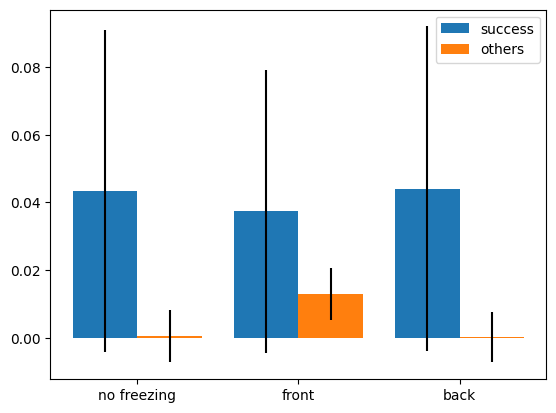

In [18]:
plot_freezing_impact(df, method="before", aligner="dico", ratio=1)

In [39]:
def plot_freezing_impact_by_language(df, task="udpos", model="distilbert-base-multilingual-cased", method="before", aligner="dico", languages=LANGUAGES):
    method_delta = []
    front_delta = []
    back_delta = []

    baseline_stddev = []
    method_stddev = []
    front_stddev = []
    back_stddev = []

    subdf = df[(df.task == task)  & (df.model == model)]
    baseline_df = subdf[subdf.method == "baseline"]
    method_df = subdf[subdf.method == f"{method}_{aligner}"]
    front_df = subdf[subdf.method == f"{method}_partial_freeze_front_{aligner}"]
    back_df = subdf[subdf.method == f"{method}_partial_freeze_back_{aligner}"]


    for lang in languages:
        baseline_value = np.mean(baseline_df[f"final_eval_{lang}_accuracy"])
        method_value = np.mean(method_df[f"final_eval_{lang}_accuracy"])
        front_value = np.mean(front_df[f"final_eval_{lang}_accuracy"])
        back_value = np.mean(back_df[f"final_eval_{lang}_accuracy"])

        baseline_stddev.append(np.std(baseline_df[f"final_eval_{lang}_accuracy"]))
        method_stddev.append(np.std(method_df[f"final_eval_{lang}_accuracy"]))
        front_stddev.append(np.std(front_df[f"final_eval_{lang}_accuracy"]))
        back_stddev.append(np.std(back_df[f"final_eval_{lang}_accuracy"]))

        method_delta.append(method_value - baseline_value)
        front_delta.append(front_value - baseline_value)
        back_delta.append(back_value - baseline_value)

    method_delta = np.array(method_delta)
    front_delta = np.array(front_delta)
    back_delta = np.array(back_delta)

    baseline_stddev = np.array(baseline_stddev)
    method_stddev = np.array(method_stddev)
    front_stddev = np.array(front_stddev)
    back_stddev = np.array(back_stddev)

    ids = np.argsort(method_delta)[::-1]

    method_delta = method_delta[ids]
    front_delta = front_delta[ids]
    back_delta = back_delta[ids]

    baseline_stddev = baseline_stddev[ids]
    method_stddev = method_stddev[ids]
    front_stddev = front_stddev[ids]
    back_stddev = back_stddev[ids]

    fig, ax=plt.subplots(figsize=(12,8))

    ax.bar(np.arange(len(languages)) - 0.2, np.zeros(np.arange(len(languages)).shape), align="edge", width=-0.2, yerr=baseline_stddev)
    ax.bar(np.arange(len(languages)), method_delta, align="edge", width=-0.2, label="no freezing", yerr=method_stddev)
    ax.bar(np.arange(len(languages)), front_delta, align="edge", width=0.2, label="front", yerr=front_stddev)
    ax.bar(np.arange(len(languages)) + 0.2, back_delta, align="edge", width=0.2, label="back", yerr=back_stddev)

    ax.set_xticks(np.arange(len(languages)))
    ax.set_xticklabels([languages[i] for i in ids])
    ax.legend()
    plt.show()


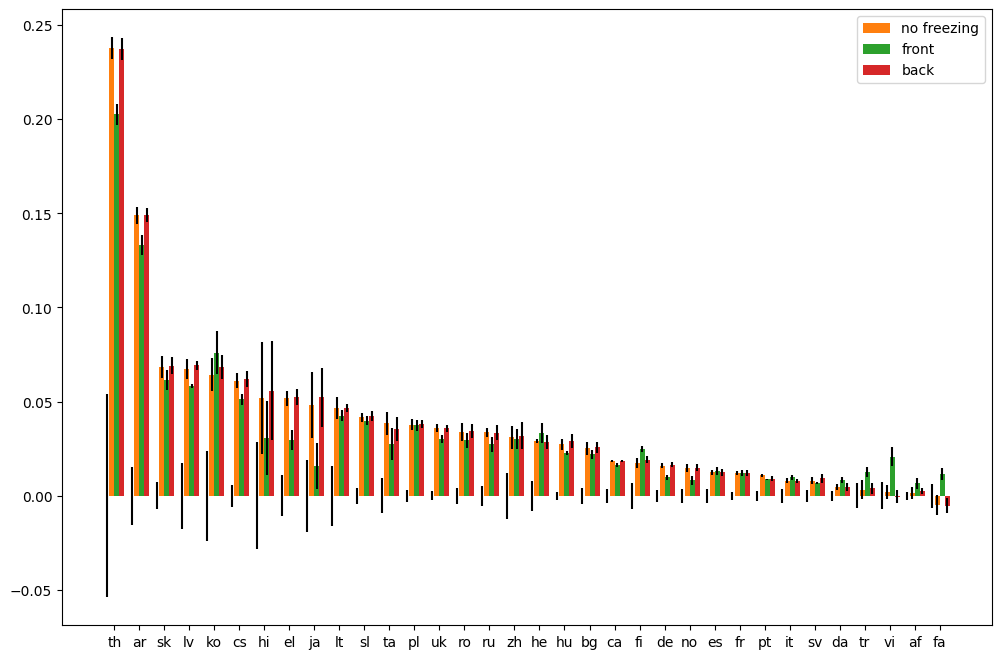

In [40]:
plot_freezing_impact_by_language(df)

## Same for XNLI

In [41]:
xnli_df = pd.read_csv("raw_results/distilbert-base-multilingual-cased__xnli__opus100.csv")
# Renaming for convenience
ALIGNERS = ["fastalign", "awesome", "dico"]

for aligner in ALIGNERS:
    xnli_df["method"] = xnli_df["method"].replace(f"freeze_realign_unfreeze_{aligner}", f"before_partial_freeze_front_{aligner}")
    xnli_df["method"] = xnli_df["method"].replace(f"freeze_realign_unfreeze_last_6_{aligner}", f"before_partial_freeze_back_{aligner}")

In [42]:
XNLI_LANGUAGES = list(filter(lambda x: x not in ["same", "avg"], map(lambda x: x[len("final_eval_"):-len("_accuracy")] , filter(lambda x: x.startswith("final_eval_") and x.endswith("_accuracy"), xnli_df.columns))))

/root/miniconda3/envs/align_freeze/lib/python3.9/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/root/miniconda3/envs/align_freeze/lib/python3.9/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
/root/miniconda3/envs/align_freeze/lib/python3.9/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/root/miniconda3/envs/align_freeze/lib/python3.9/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
/root/miniconda3/envs/align_freeze/lib/python3.9/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a

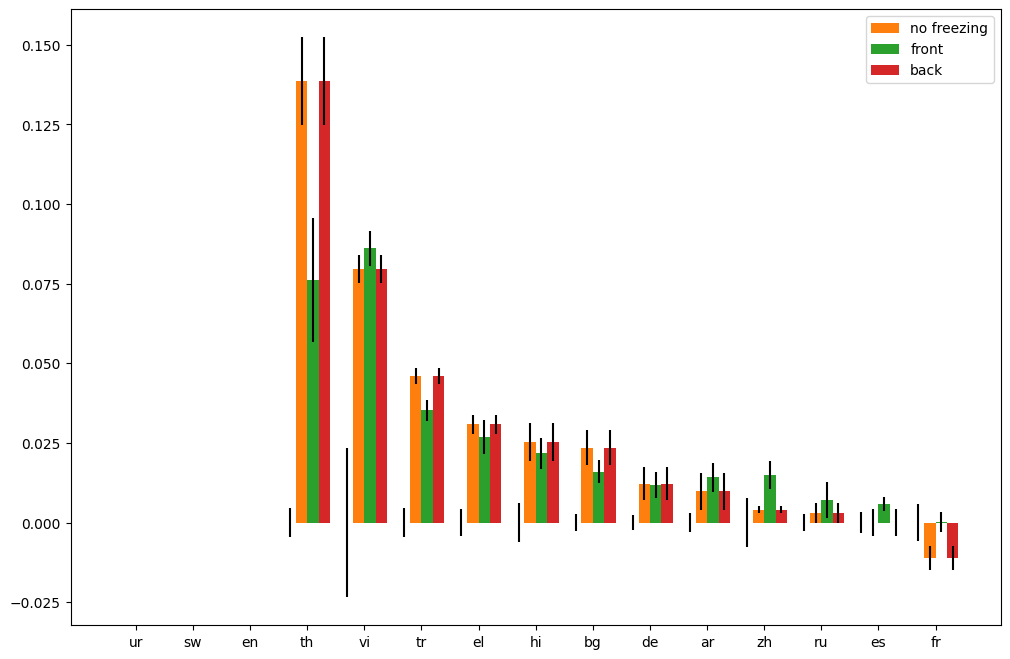

In [45]:
plot_freezing_impact_by_language(xnli_df, task="xnli", languages=XNLI_LANGUAGES)

In [44]:
xnli_df.head()

,seed,model,task,method,finetuning_steps,realignment_steps,distinct_realignment_samples,repeated_realignment_samples,train_loss,realignment_loss,...,final_eval_hi_accuracy,final_eval_ru_accuracy,final_eval_sw_accuracy,final_eval_th_accuracy,final_eval_tr_accuracy,final_eval_ur_accuracy,final_eval_vi_accuracy,final_eval_zh_accuracy,final_eval_avg_accuracy,final_eval_same_accuracy
0,31,distilbert-base-multilingual-cased,xnli,before_fastalign,24544,24544,392704,392704,0.565891,0,...,0.566267,0.644511,NaN,0.500000,0.620758,NaN,0.657485,0.662076,0.636810,0.773852
1,42,distilbert-base-multilingual-cased,xnli,before_fastalign,24544,24544,392704,392704,0.176881,0,...,0.560279,0.641517,NaN,0.473453,0.609780,NaN,0.656487,0.648303,0.627229,0.778443
2,66,distilbert-base-multilingual-cased,xnli,before_fastalign,24544,24544,392704,392704,0.705611,0,...,0.557485,0.645509,NaN,0.465669,0.612375,NaN,0.657485,0.648703,0.626015,0.776647
3,23,distilbert-base-multilingual-cased,xnli,before_fastalign,24544,24544,392704,392704,0.548444,0,...,0.561876,0.652295,NaN,0.445908,0.610978,NaN,0.656287,0.650699,0.629375,0.776447
4,17,distilbert-base-multilingual-cased,xnli,before_fastalign,24544,24544,392704,392704,0.535980,0,...,0.568263,0.645509,NaN,0.466667,0.607186,NaN,0.650699,0.647106,0.627778,0.776248


### UDPOS with XLM-R

In [71]:
import wandb
import csv
import json

api = wandb.Api()

langs = ["same", "avg", "af", "ar", "bg", "ca", "cs", "da", "de", "el", "es", "fa", "fi", "fr", "he", "hi",
         "hu", "it", "ja", "ko", "lt", 'lv', 'no', 'pl', 'pt', 'ro', 'ru', 'sk', 'sl', 'sv', 'ta', 'th', 'tr', 'uk',
         'vi', 'zh']

In [74]:
def create_csv_from_wandb(output_file: str, columns, prefix="3nl_34langs", username="felixgaschi", langs=langs, workspace = "align_freeze"):
   
    
    project_names = [f"{prefix}_{method}" for method in [
        "baseline_udpos",
        *[
            f"{method}_{aligner}_udpos"
            for method in ["before", "during"]
            for aligner in ALIGNERS
        ],
        *[
            f"freeze_realign_unfreeze_{aligner}_udpos"
            for aligner in ALIGNERS
        ],
        *[
            f"freeze_realign_unfreeze_last_6_{aligner}_udpos"
            for aligner in ALIGNERS
        ]
    ]]

    with open(output_file, "w") as f:
        writer = csv.writer(f)
        writer.writerow(columns)

        for name in project_names:
            runs = api.runs(f"{workspace}/{name}")

            for run in runs:
                if run.user.username == username:  
                    new_row = []
                    config = json.loads(run.json_config)
                    for c in columns:
                        if c in ["seed", "model", "task", "method"]:
                            new_row.append(config[c]["value"])
                        else:
                            new_row.append(run.summary.get(c))
                    writer.writerow(new_row)


In [75]:
create_csv_from_wandb("raw_results/xlm-roberta-base__opus100.csv", list(df.columns))

In [79]:
xlm_df = pd.read_csv("raw_results/xlm-roberta-base__opus100.csv")

for aligner in ALIGNERS:
    xlm_df["method"] = xlm_df["method"].replace(f"freeze_realign_unfreeze_{aligner}", f"before_partial_freeze_front_{aligner}")
    xlm_df["method"] = xlm_df["method"].replace(f"freeze_realign_unfreeze_last_6_{aligner}", f"before_partial_freeze_back_{aligner}")

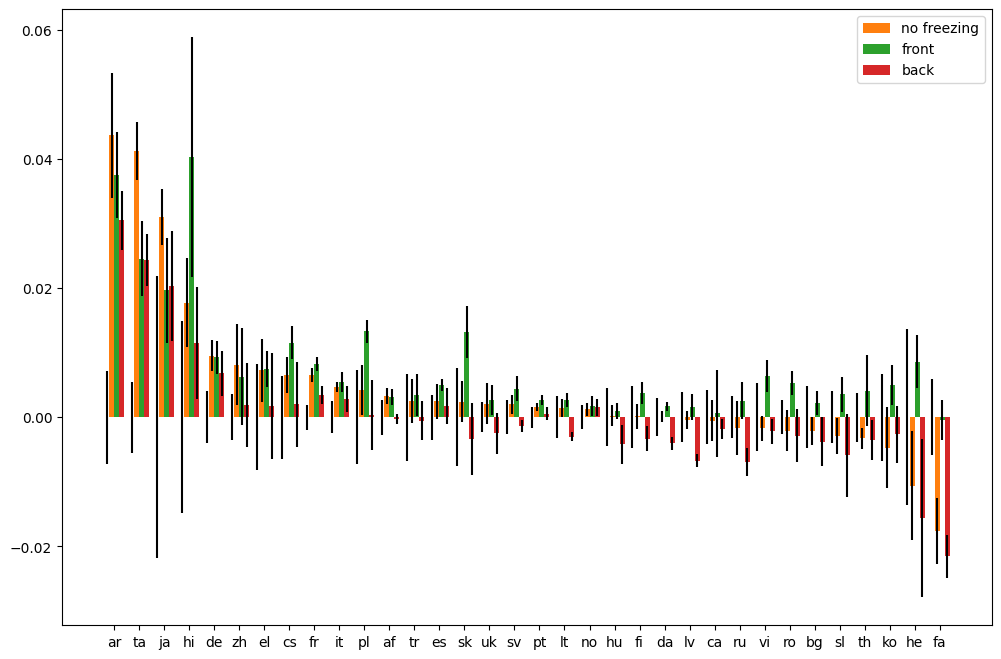

In [80]:
plot_freezing_impact_by_language(xlm_df, model="xlm-roberta-base")